In [1]:
from functions import *
from process_text import *
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import sklearn
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import random
from sklearn.model_selection import cross_validate as cvt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier as dtc
from copy import deepcopy as dp

In [2]:
test, train = load_pkl(r'C:\Users\HEndo\Documents\GitHub\zemi\cleaned_corpus\base_cleaned.pkl')
test_a, train_a = load_pkl(r'C:\Users\HEndo\Documents\GitHub\zemi\cleaned_corpus\org_answer_data.pkl')
train_X = dp(train)
train_Y = dp(train_a)
test, train_2 = load_pkl(r'cleaned_corpus/augmented_corpus.pkl')
test_a, train_a2 = load_pkl(r'cleaned_corpus/augmented_org_ans.pkl')
train_X2 = dp(train_2)
train_Y2 = dp(train_a2)
trees = []

In [3]:
def create_model(_min, _max, mx_depth, mn_sp, mx_feat, ngram = (1,2), X = train_X, y = train_Y, cw = None):
    sw = stopwords.words('english') + ['hes']
    data = list(zip(X, y))
    random.shuffle(data)
    ff_train, ff_train_a = zip(*data)
    ff_train = [' '.join(text) for text in ff_train]
    vect = TfidfVectorizer(stop_words=sw,tokenizer=tokenize, 
                          min_df= _min, max_df=_max, 
                          ngram_range=ngram)
    tfidf = vect.fit_transform(ff_train)
    tree = dtc(max_depth=mx_depth, 
               min_samples_split= mn_sp,
               max_features= mx_feat,
               class_weight= cw
              )
    tree.fit(tfidf, ff_train_a)
    test_x= [' '.join(text) for text in test]
    test_X = vect.transform(test_x)
    prediction = tree.predict(test_X)
    cmx = print_cmx(y_true=test_a, y_pred=prediction)
    
    return tree

In [4]:
normal_best_params = load_pkl('tuning/tuned_parameters/decision_tree/decision_tree.pkl')
nbp = normal_best_params
normal_best_params

{'_min': 0.003941570792418628,
 '_max': 0.7,
 'ngram': (1, 2),
 'mx_depth': 20.0,
 'mn_sp': 0.17573596009797782,
 'mn_lf': 1,
 'mx_feat': 0.8376154434188189}

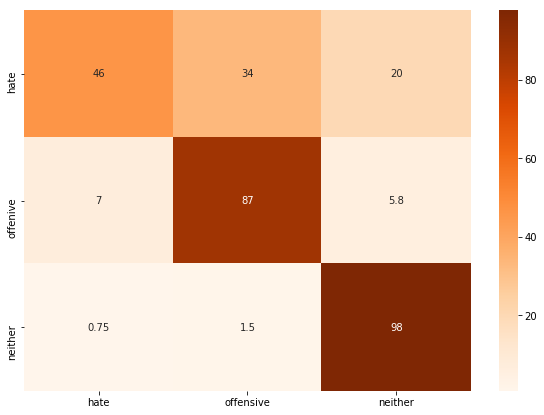

[[ 65  47  28]
 [ 35 436  29]
 [  3   6 391]]
              precision    recall  f1-score   support

           0       0.63      0.46      0.53       140
           1       0.89      0.87      0.88       500
           2       0.87      0.98      0.92       400

   micro avg       0.86      0.86      0.86      1040
   macro avg       0.80      0.77      0.78      1040
weighted avg       0.85      0.86      0.85      1040



In [5]:
tree = create_model(nbp['_min'], nbp['_max'], nbp['mx_depth'], nbp['mn_sp'], nbp['mx_feat'], ngram = nbp['ngram'])
trees.append(tree)

In [6]:
class_weight_best_params = load_pkl('tuning/tuned_parameters/decision_tree/decision_tree_class_weight.pkl')
cbp = class_weight_best_params
class_weight_best_params

{'_min': 0.004,
 '_max': 0.75,
 'ngram': (1, 2),
 'mx_depth': 20,
 'mn_sp': 0.18,
 'mn_lf': 1,
 'mx_feat': 0.85}

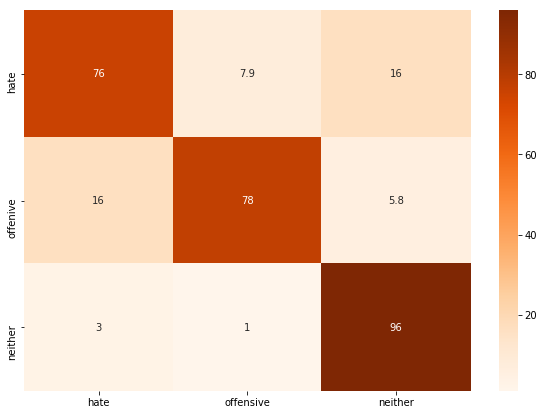

[[106  11  23]
 [ 82 389  29]
 [ 12   4 384]]
              precision    recall  f1-score   support

           0       0.53      0.76      0.62       140
           1       0.96      0.78      0.86       500
           2       0.88      0.96      0.92       400

   micro avg       0.85      0.85      0.85      1040
   macro avg       0.79      0.83      0.80      1040
weighted avg       0.87      0.85      0.85      1040



In [7]:
tree_cw = create_model(cbp['_min'], cbp['_max'], cbp['mx_depth'], cbp['mn_sp'], cbp['mx_feat'], ngram = cbp['ngram'], cw = 'balanced')
trees.append(tree_cw)

In [8]:
augmented_best_params = load_pkl('tuning/tuned_parameters/decision_tree/decision_tree_augmented.pkl')
abp = augmented_best_params
augmented_best_params

{'_min': 0.0010076069969777687,
 '_max': 0.893393602554536,
 'mx_depth': 80.0,
 'mn_sp': 0.1550354937299351,
 'mx_feat': 0.8211110248572838}

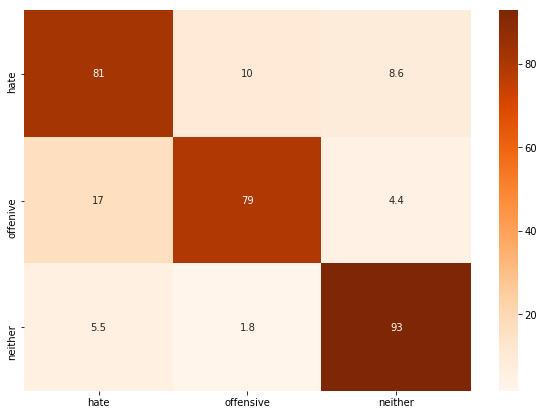

[[114  14  12]
 [ 83 395  22]
 [ 22   7 371]]
              precision    recall  f1-score   support

           0       0.52      0.81      0.64       140
           1       0.95      0.79      0.86       500
           2       0.92      0.93      0.92       400

   micro avg       0.85      0.85      0.85      1040
   macro avg       0.80      0.84      0.81      1040
weighted avg       0.88      0.85      0.85      1040



In [10]:
tree_aug = create_model(abp['_min'], abp['_max'], abp['mx_depth'], abp['mn_sp'], abp['mx_feat'], ngram = (1,2), X = train_X2, y = train_Y2)
trees.append(tree_aug)

In [12]:
trees = [tree, tree_cw, tree_aug]
save_pkl('final_models/decision_tree.pkl', trees[0])
save_pkl('final_models/decision_tree_class_weight.pkl', trees[1])
save_pkl('final_models/decision_tree_augmented.pkl', trees[2])

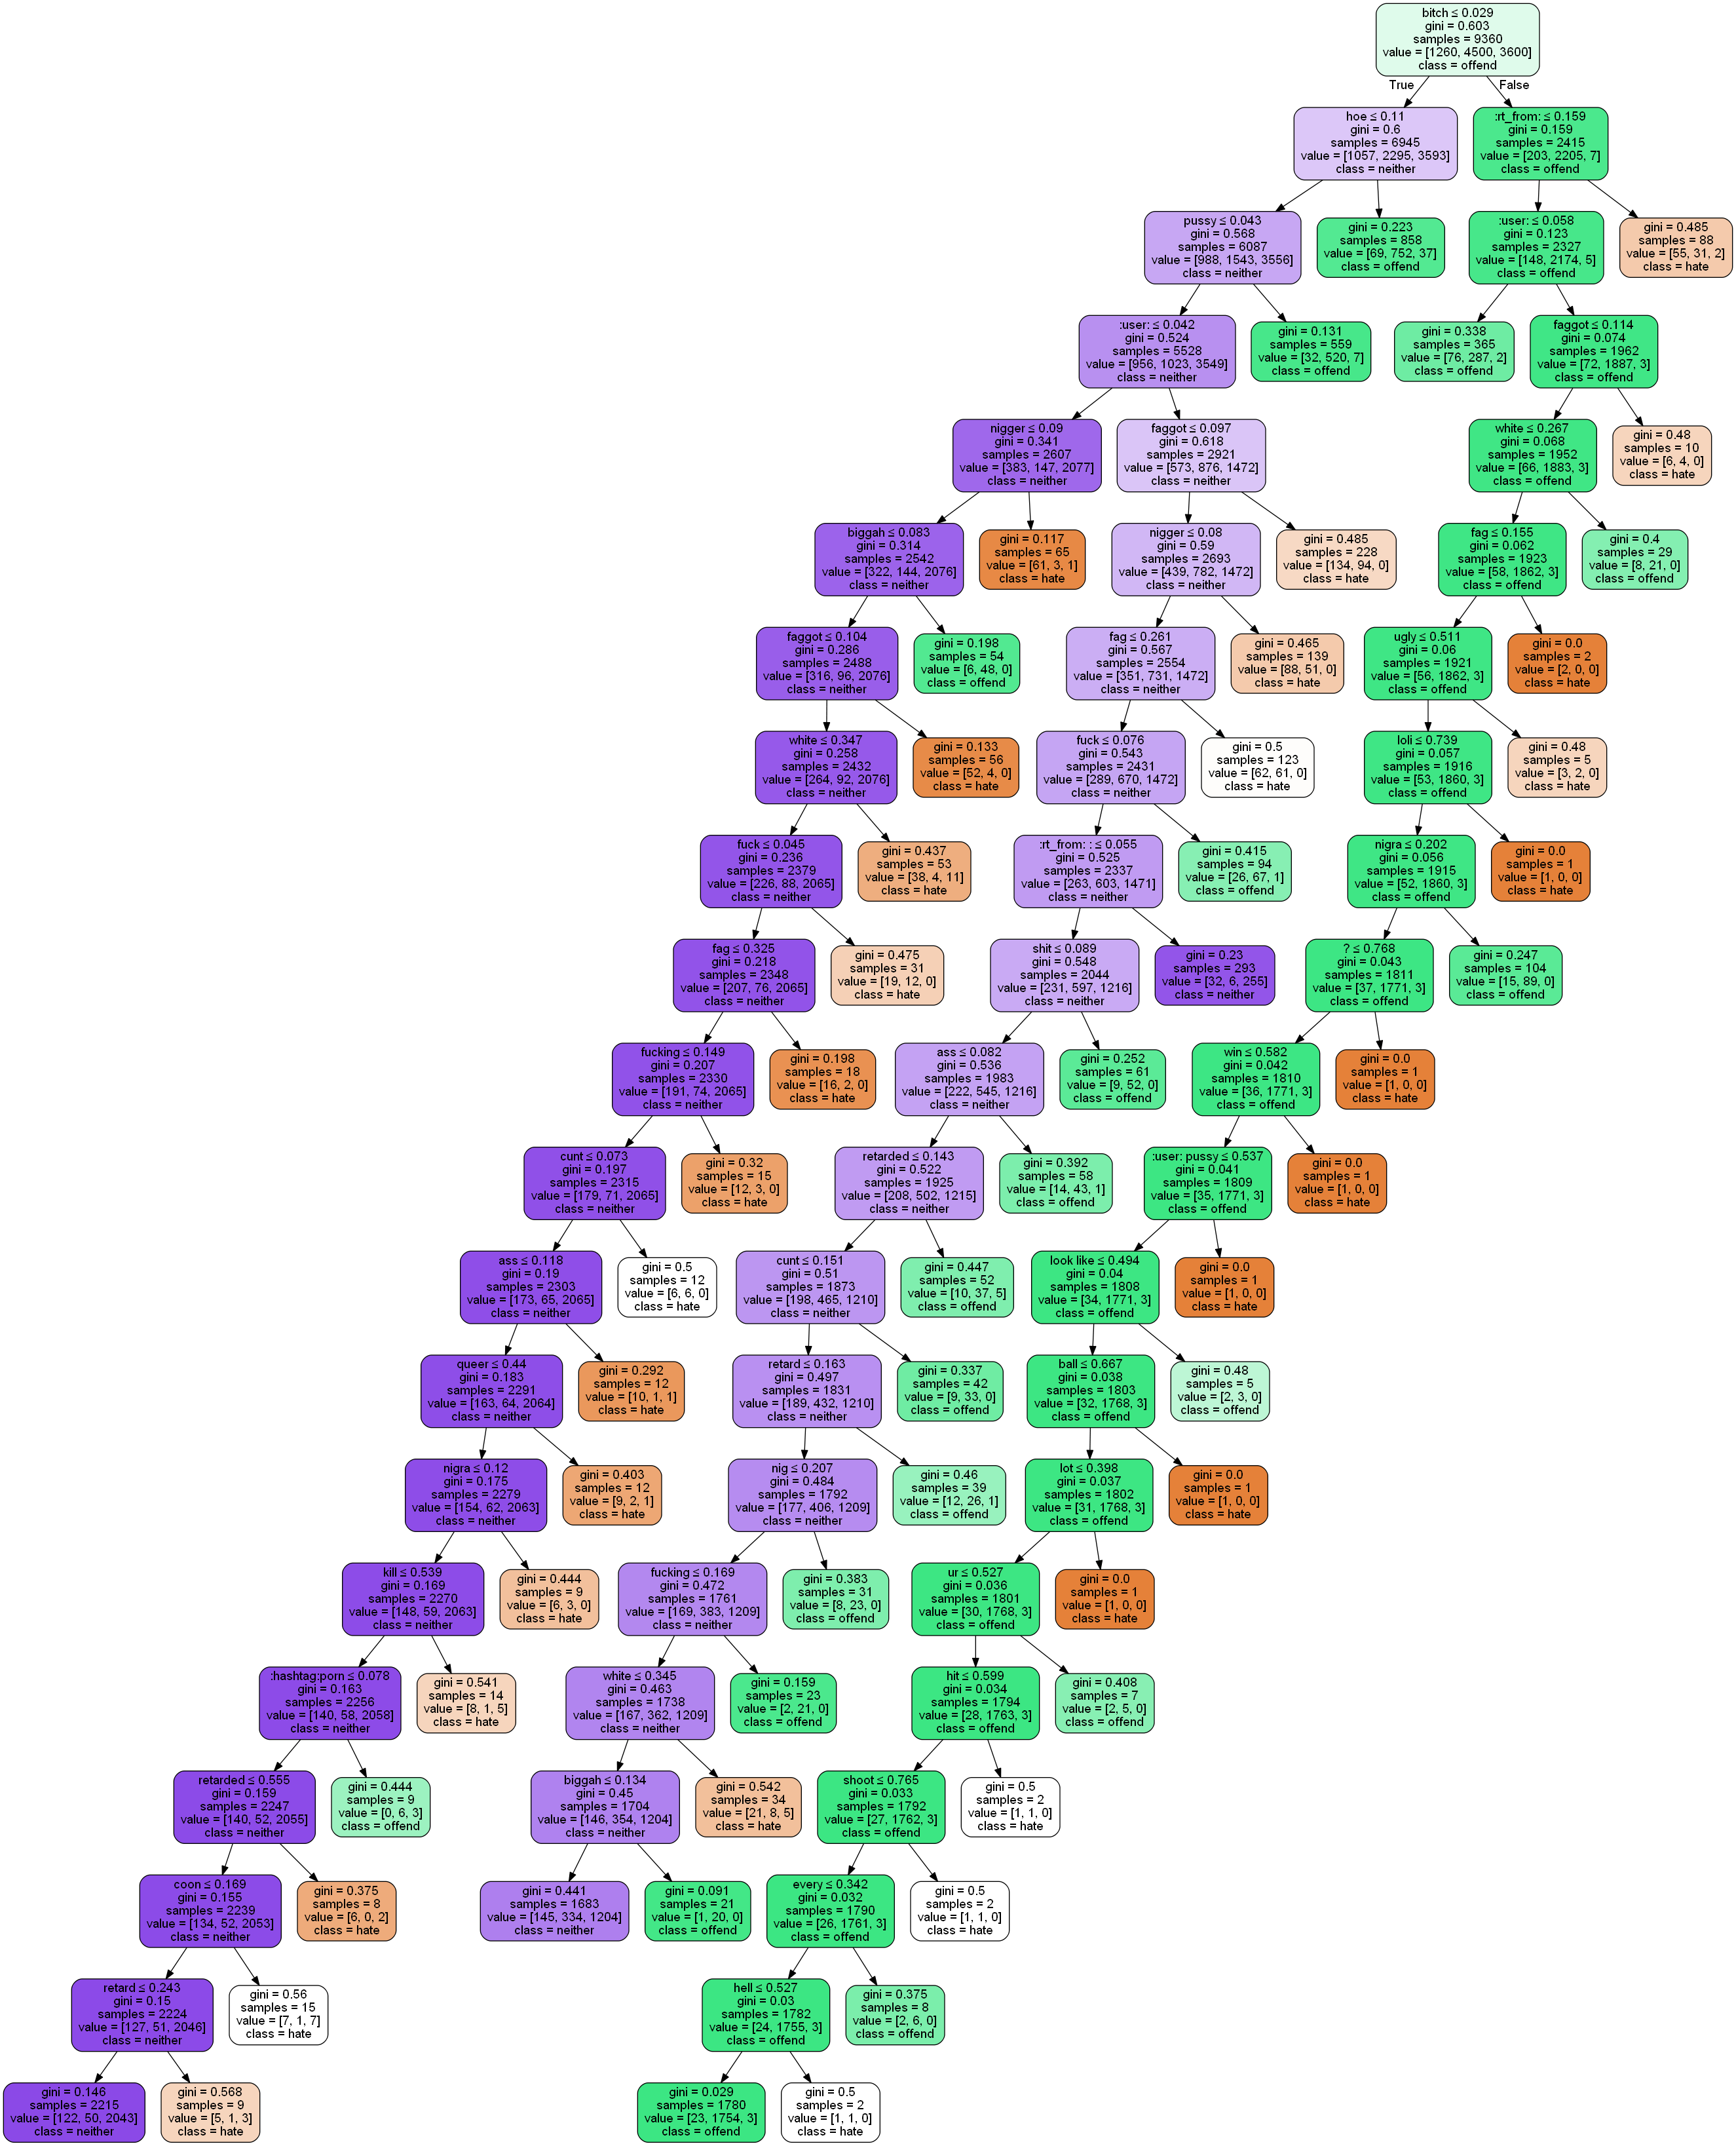

In [36]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import re
n_fn = vect.get_feature_names()
n_fn = [re.sub('[<>]', ':', text) for text in n_fn]
n_fn = [re.sub('[#]', ':hashtag:', text) for text in n_fn]
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names = n_fn,
                class_names= ['hate', 'offend', 'neither']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [37]:
graph.write_png('decision_tree.png')

True

In [80]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import re
n_fn = vect.get_feature_names()
n_fn = [re.sub('[<>]', ':', text) for text in n_fn]
n_fn = [re.sub('[#]', ':hashtag:', text) for text in n_fn]
dot_data = StringIO()
export_graphviz(tree_aug, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names = n_fn,
                class_names= ['hate', 'offend', 'neither']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [83]:
graph.write_png('aug_dectree.png')

True